In [1]:
import sympy as sp
import time
from cnspy import cns
from cnspy import method
from cnspy import adaptive, adaptive_parameters
import mpmath
mpmath.mp.dps =500
t = sp.symbols(r't')
N = 5
F = sp.symbols(r'F')
u=sp.symarray('x', N)
fun = []
for i in range(0,N):
    fun.append( (u[(i+1)%N]-u[i-2])*u[i-1]-u[i]+F )

In [2]:
from cnspy import cluster
HN = cluster.ssh()
HN.connect()
HN.execute('sinfo')

Connected to the 192.168.1.247 server
Executing command: sinfo
Command output:
PARTITION AVAIL  TIMELIMIT  NODES  STATE NODELIST
normal*      up   infinite     11    mix cu[1-4,6,9,11-14,18]
normal*      up   infinite      7   idle cu[5,7-8,10,15-17]
fat          up   infinite      2   idle cu[19-20]

Command error (if any):



In [2]:
lorenz96=cns(funcs=fun,name="lorenz96",\
           method=method('TS'),\
           inits=[[u[0],"8.01"],[u[1],"8"],[u[2],"8"],[u[3],"8"],[u[4],"8"]],\
           paras=[[F,"8"]],\
           tspan=(0,1000),\
           saveat=0.1,\
           lyap=0.48,\
           adaptive=adaptive('t','order','wordsize',delta_T=50,remaining_T=500,gamma=1.15),\
           mpi=True,\
           run_os= 'posix',\
           printprecision= 500,\
           numofprocessor=64)

Predefine wordsize is 794.
Predefine order is 367.


In [3]:
lorenz96.generate_c_code()

In [ ]:
from cnspy import cluster
SL = cluster.slurm_script(node='cu10', qos='super', np=lorenz96.numofprocessor, jobname = lorenz96.name)
HN = cluster.ssh()
lorenz96.run(HN,SL)

In [3]:
#read result
lorenz96.read_cnssol()
#rk4 result
lorenz96.quick_run()

In [4]:
lorenz96_higher=cns(funcs=fun,name="lorenz96_higher",\
           method=method('TS',order=400,nosd=300),\
           inits=[[u[0],"8.01"],[u[1],"8"],[u[2],"8"],[u[3],"8"],[u[4],"8"]],\
           paras=[[F,"8"]],\
           tspan=(0,1000),\
           saveat=0.1,\
           lyap=0.48,\
           adaptive=adaptive('t'),\
           mpi=True,\
           printprecision= 500,\
           numofprocessor=64)

Predefine wordsize is 997.
Predefine order is 400.


In [5]:
lorenz96_higher.generate_c_code()

In [ ]:
from cnspy import cluster
SL = cluster.slurm_script(node='cu5', qos='super', np=lorenz96_higher.numofprocessor, jobname = lorenz96_higher.name)
HN = cluster.ssh()
lorenz96_higher.run(HN,SL)

In [5]:
#read result
lorenz96_higher.read_cnssol()
#rk4 result
lorenz96_higher.quick_run()

In [6]:
lorenz96_fix=cns(funcs=fun,name="lorenz96_fix",\
           method=method('TS',order=338,nosd=225),\
           inits=[[u[0],"8.01"],[u[1],"8"],[u[2],"8"],[u[3],"8"],[u[4],"8"]],\
           paras=[[F,"8"]],\
           tspan=(0,1000),\
           saveat=0.1,\
           lyap=0.48,\
           adaptive=adaptive('t'),\
           mpi=True,\
           printprecision= 500,\
           numofprocessor=64)

Predefine wordsize is 748.
Predefine order is 338.


In [7]:
lorenz96_fix.generate_c_code()

In [ ]:
from cnspy import cluster
SL = cluster.slurm_script(node='cu10', qos='super', np=lorenz96_fix.numofprocessor, jobname = lorenz96_fix.name)
HN = cluster.ssh()
lorenz96_fix.run(HN,SL)

In [7]:
#read result
lorenz96_fix.read_cnssol()
#rk4 result
lorenz96_fix.quick_run()

In [8]:
import sympy as sp
def relative_error(y1, y2):
    for j in range(len(y1[:,0])):
        if j == 0:
            era = [sp.Float(abs(y1[j,i] - y2[j,i])) for i in range(len(y1[0,:]))]
            erb = [sp.Float(abs(y2[j,i])) for i in range(len(y1[0,:]))]
        else:
            era = [ era[i] + sp.Float(abs(y1[j,i] - y2[j,i])) for i in range(len(y1[0,:]))]
            erb = [ erb[i] + sp.Float(abs(y2[j,i])) for i in range(len(y1[0,:]))]
    return [era[i] / erb[i] for i in range(len(era))]

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
Failed to find a Ghostscript installation.  Distillation step skipped.


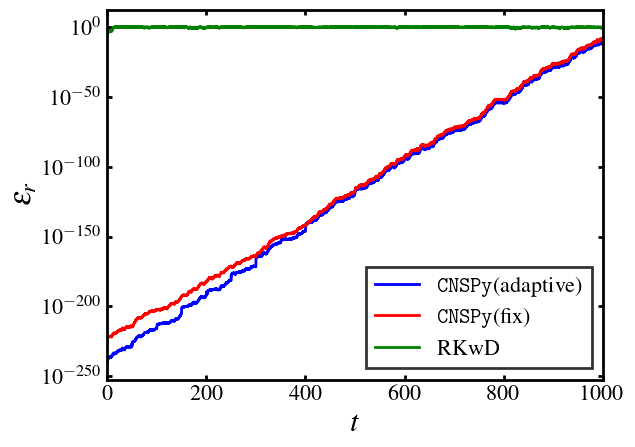

In [10]:
import matplotlib.pyplot as plt
from matplotlib import rc
rc("legend",fancybox=False)
rc('text', usetex=True)
rc('text.latex', preamble=r'\usepackage{amsmath} \boldmath')
rc('patch',linewidth=2)
font = {'family' : 'serif',
        'serif':['Times'],
        'weight' : 'bold',
        'size'   : 16}
rc('font', **font)
from matplotlib.ticker import FuncFormatter

x = lorenz96.cnssol.t[1:]
y1 = relative_error(lorenz96.cnssol.y, lorenz96_higher.cnssol.y)[1:]
y2 = relative_error(lorenz96_fix.cnssol.y, lorenz96_higher.cnssol.y)[1:]
y3 = relative_error(lorenz96.qrsol.y, lorenz96_higher.cnssol.y)[1:]
def log_formatter(x, pos):
    return "$10^{{{:d}}}$".format(int(x))

formatter = FuncFormatter(log_formatter)

fig, ax = plt.subplots()

y11 = list(map(lambda x:sp.log(x, 10), y1))
y22 = list(map(lambda x:sp.log(x, 10), y2))
y33 = list(map(lambda x:sp.log(x, 10), y3))
ax.plot(x, y11,label=r'\texttt{CNSPy}(adaptive)',linestyle="-",linewidth=2,color="blue")
ax.plot(x, y22,label=r'\texttt{CNSPy}(fix)',linestyle="-",linewidth=2,color="red")
ax.plot(x, y33,label=r'RKwD',linestyle="-",linewidth=2,color="green")
ax.yaxis.set_major_formatter(formatter)
ax.set_xlim(0,1000)
ax.set_xlabel(r'$\boldsymbol{t}$', fontsize=22, fontweight='bold')
ax.set_ylabel(r'$\boldsymbol{\epsilon_r}$', fontsize=22, fontweight='bold')
ax.tick_params(direction="in",top=True,right=True,width=2)
ax.legend(edgecolor="inherit",loc="best")
for location in  ["left", "right", "top", "bottom"]:
    ax.spines[location].set_linewidth(2)

fig.savefig("lorenz96_error.eps",bbox_inches='tight')


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
Failed to find a Ghostscript installation.  Distillation step skipped.


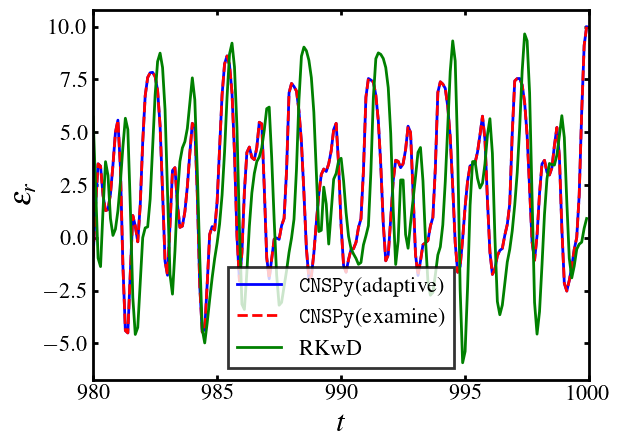

In [11]:
#plot phase space
import matplotlib.pyplot as plt
from matplotlib import rc
rc("legend",fancybox=False)
rc('text', usetex=True)
rc('text.latex', preamble=r'\usepackage{amsmath} \boldmath')
rc('patch',linewidth=2)
font = {'family' : 'serif',
        'serif':['Times'],
        'weight' : 'bold',
        'size'   : 16}
rc('font', **font)
fig, ax = plt.subplots()
ax.plot(lorenz96.cnssol.t[9800:10000],lorenz96.cnssol.y[0,9800:10000],label=r'\texttt{CNSPy}(adaptive)',linestyle="-",linewidth=2,color="blue")
ax.plot(lorenz96_higher.cnssol.t[9800:10000],lorenz96_higher.cnssol.y[0,9800:10000],label=r'\texttt{CNSPy}(examine)',linestyle="--",linewidth=2,color="red")
ax.plot(lorenz96.qrsol.t[9800:10000],lorenz96.qrsol.y[0,9800:10000],label=r'RKwD',linestyle="-",linewidth=2,color="green")

ax.set_xlim(980,1000)
ax.set_xlabel(r'$\boldsymbol{t}$', fontsize=22, fontweight='bold')
ax.set_ylabel(r'$\boldsymbol{\epsilon_r}$', fontsize=22, fontweight='bold')
ax.tick_params(direction="in",top=True,right=True,width=2)
ax.legend(edgecolor="inherit",loc="best")
for location in  ["left", "right", "top", "bottom"]:
    ax.spines[location].set_linewidth(2)

fig.savefig("lorenz96_x1.eps",bbox_inches='tight')

In [12]:
import numpy as np
import mpmath
def order_nosd_time(system):
    magic_number = system.adptv_para.magic_number
    gamma = system.adptv_para.gamma
    remaining_T = system.adptv_para.remaining_T
    lyap = system.lyap 
    tmax = system.tspan[1]
    time = [i for i in range(0, tmax+1)]
    delta_T = system.adptv_para.delta_T
    order = np.zeros(len(time))
    nosd = np.zeros(len(time))
    desire_error = []
    desire_time = []
    for i in range(0, len(time)):
        if i % delta_T == 0 and i <= tmax - remaining_T:
            nosd[i] = int(gamma*lyap*(tmax-i)/np.log(10.0))
            desire_error.append(10**(-mpmath.mp.mpf(nosd[i])))
            desire_time.append(i)
        else:
            nosd[i] = nosd[i-1]
        order[i] = int(magic_number[0]*nosd[i]*nosd[i]+magic_number[1]*nosd[i]+magic_number[2])
        order[-1] = order[-2]
        nosd[-1] = nosd[-2]
        
    return time, np.array(desire_time), order, nosd, np.array(desire_error)
    

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
Failed to find a Ghostscript installation.  Distillation step skipped.


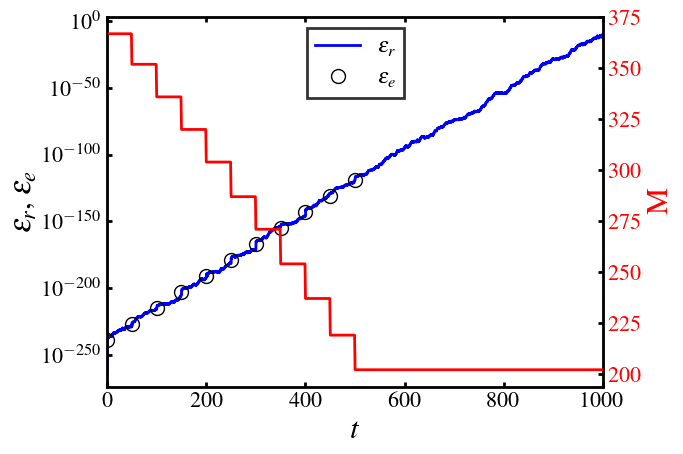

In [13]:
import matplotlib.pyplot as plt
from matplotlib import rc
rc("legend",fancybox=False)
rc('text', usetex=True)
rc('text.latex', preamble=r'\usepackage{amsmath} \boldmath')
rc('patch',linewidth=2)
font = {'family' : 'serif',
        'serif':['Times'],
        'weight' : 'bold',
        'size'   : 16}
rc('font', **font)
from matplotlib.ticker import FuncFormatter

x = lorenz96.cnssol.t
y1 = relative_error(lorenz96.cnssol.y, lorenz96_higher.cnssol.y)
t_lorenz96, desire_time_lorenz96, order_lorenz96, nosd_lorenz96, desire_error_lorenz96 = order_nosd_time(lorenz96)
def log_formatter(x, pos):
    return "$10^{{{:d}}}$".format(int(x))

formatter = FuncFormatter(log_formatter)

fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
y11 = list(map(lambda x:sp.log(x, 10), y1))
y22 = list(map(lambda desire_time_lorenz96:sp.log(desire_time_lorenz96, 10), desire_error_lorenz96))
ax1.plot(x, y11,label=r'$\boldsymbol{\epsilon_{r}}$',linestyle="-",linewidth=2,color='blue')
ax1.plot(desire_time_lorenz96, y22,label=r'$\boldsymbol{\epsilon_{e}}$',marker="o", markersize=10,color='none', markerfacecolor='none', markeredgecolor="black")
ax2.plot(x[::10], order_lorenz96,label='order',linestyle="-",linewidth=2,color='red')
ax2.tick_params(direction="in",axis='y', labelcolor='red',width=2)
ax2.set_ylabel(r'M', fontsize=22, color='red', fontweight='bold')
ax1.yaxis.set_major_formatter(formatter)
ax1.set_xlim(0,1000)
ax1.set_xlabel(r'$\boldsymbol{t}$', fontsize=22, fontweight='bold')
ax1.set_ylabel(r'$\boldsymbol{\epsilon_r}$, $\boldsymbol{\epsilon_e}$', fontsize=22, fontweight='bold')
ax1.tick_params(direction="in",top=True,width=2)
ax1.legend(edgecolor="inherit",loc="upper center")
for location in  ["left", "right", "top", "bottom"]:
    ax1.spines[location].set_linewidth(2)

fig.savefig("algorithm_lorenz96.eps",bbox_inches='tight')